In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../smplx-estimation/smplx_estimation/utils/')
from rot3d_conversions import axis_angle_to_matrix, matrix_to_axis_angle

/mnt/vol_b/miniconda3/envs/smplerx/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np
import torch
import deepdish as dd
import matplotlib.pyplot as plt
import cv2
import smplx
import os

In [4]:
def plot_points_on_image(image, points, color=(0, 0, 255), radius=3, thickness=-1):
    """
    Plots a batch of 2D points on an image using OpenCV.

    Args:
        image (numpy.ndarray): The image to plot the points on.
        points (numpy.ndarray): A 2D array of shape (batch_size, 2) containing 
                                the (x, y) coordinates of the points.
        color (tuple, optional): The color of the points in BGR format. 
                                 Defaults to (0, 0, 255) (blue).
        radius (int, optional): The radius of the points. Defaults to 3.
        thickness (int, optional): The thickness of the point's circle. A value
                                   of -1 will fill the circle. Defaults to -1.
    """

    # Make a copy of the image so we don't modify the original
    image_copy = image.copy() 

    # Iterate through each point in the batch
    for x, y in points:
        center_coordinates = (int(x), int(y))  # Convert to integer coordinates
        cv2.circle(image_copy, center_coordinates, radius, color, thickness)

    return image_copy 

device = 'cpu'
smplx_model = smplx.create(
    os.path.join('../smplx-estimation/weights/smplx/SMPLX_NEUTRAL.npz'),
    model_type='smplx',
    gender='neutral', use_face_contour=False,
    num_betas=10, flat_hand_mean=False,
    num_expression_coeffs=10,
    ext='npz', use_pca=False
).to(device)

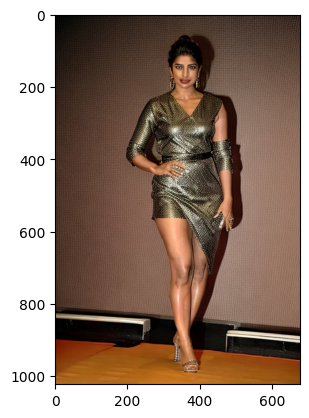

In [6]:
image_path = '/mnt/vol_f/control-human-gen-v2/laion-faces/generations/densepose_gen_l32_shape_resampled/t2023120219/laion_face/p00003/id6646112.jpg'
label_path = '/mnt/vol_f/control-human-gen-v2/laion-faces/smplerx-pred-v3-dp/t2023120219/laion_face/p00003/id6646112.h5'

img_orig = cv2.imread(image_path)[..., ::-1].copy()
img_shape = img_orig.shape[:2]
avatar_info = dd.io.load(label_path)
plt.imshow(img_orig)

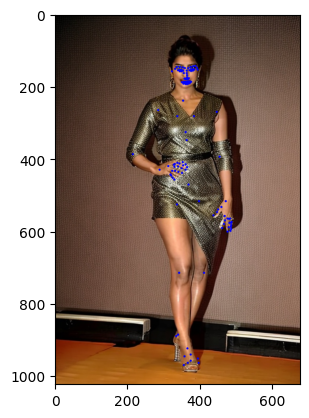

In [7]:
with torch.no_grad():
    smplx_output = smplx_model(
        betas=torch.from_numpy(avatar_info['betas_shape_resampled']).to(device)[None],
        expression=torch.from_numpy(avatar_info['expression']).to(device)[None],
        global_orient=torch.from_numpy(avatar_info['global_orient']).to(device)[None],
        body_pose=torch.from_numpy(avatar_info['body_pose']).to(device)[None],
        jaw_pose=torch.from_numpy(avatar_info['jaw_pose']).to(device)[None],
        leye_pose=torch.from_numpy(avatar_info['leye_pose']).to(device)[None],
        reye_pose=torch.from_numpy(avatar_info['reye_pose']).to(device)[None],
        left_hand_pose=torch.from_numpy(avatar_info['left_hand_pose']).to(device)[None],
        right_hand_pose=torch.from_numpy(avatar_info['right_hand_pose']).to(device)[None],
    )
f=torch.from_numpy(avatar_info['focal']).to(device)
pp=torch.from_numpy(avatar_info['princpt']).to(device)
t=torch.from_numpy(avatar_info['transl']).to(device)

v3 = smplx_output.joints[0] + t
v2 = f * (v3[:, :2] / v3[:, 2:]) + pp
v2 = v2.cpu().numpy()
plt.imshow(plot_points_on_image(img_orig, v2))

### Apply 2D rotation to the image

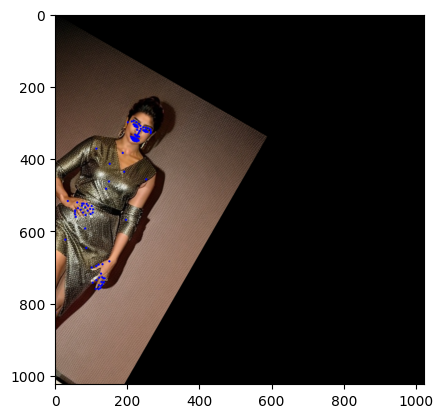

In [7]:
theta = np.deg2rad(30)
R = np.array([
    [np.cos(theta), -np.sin(theta), 0],
    [np.sin(theta), np.cos(theta), 0],
    [0, 0, 1]
])

v2_rot = v2 @ R[:2, :2].T

img_rot = cv2.warpAffine(img_orig, R[:2, :3], (1024, 1024))
plt.imshow(plot_points_on_image(img_rot, v2_rot))

### Apply Rotation to global orient of avatar and inverse to camera


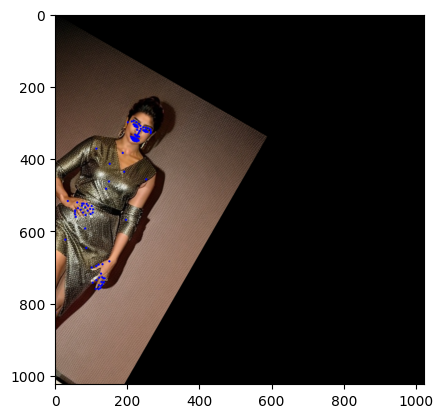

In [11]:
R_added = torch.from_numpy(R).to(device, dtype=torch.float32)
global_orient_rot = torch.bmm(
    R_added[None],
    axis_angle_to_matrix(torch.from_numpy(avatar_info['global_orient']).to(device))
)

global_orient_rot = matrix_to_axis_angle(global_orient_rot)

with torch.no_grad():
    smplx_output = smplx_model(
        betas=torch.from_numpy(avatar_info['betas_shape_resampled']).to(device)[None],
        expression=torch.from_numpy(avatar_info['expression']).to(device)[None],
        # global_orient=torch.from_numpy(avatar_info['global_orient']).to(device)[None],
        global_orient=global_orient_rot[None],
        body_pose=torch.from_numpy(avatar_info['body_pose']).to(device)[None],
        jaw_pose=torch.from_numpy(avatar_info['jaw_pose']).to(device)[None],
        leye_pose=torch.from_numpy(avatar_info['leye_pose']).to(device)[None],
        reye_pose=torch.from_numpy(avatar_info['reye_pose']).to(device)[None],
        left_hand_pose=torch.from_numpy(avatar_info['left_hand_pose']).to(device)[None],
        right_hand_pose=torch.from_numpy(avatar_info['right_hand_pose']).to(device)[None],
    )

f=torch.from_numpy(avatar_info['focal']).to(device)
pp=torch.from_numpy(avatar_info['princpt']).to(device)
t=torch.from_numpy(avatar_info['transl']).to(device)

pelvis = smplx_output.joints[0, 0]

v3 = smplx_output.joints[0] + R_added @ (t - R_added.T @ pelvis + pelvis )
v2 = f * (v3[:, :2] / v3[:, 2:]) + R_added[:2, :2] @ pp
v2 = v2.cpu().numpy()
plt.imshow(plot_points_on_image(img_rot, v2))

### Conclusions

If we add R to global orient ($R_{global} = R \cdot R_{global}$), then camera shoud be updated accordingly:

$$R_{cam} = R^T \cdot R_{cam}$$
$$T_{cam} = -R^T \cdot P + P + T_{cam}$$
$P$ - location of pelvis (after adding blendshapes in t pose)

If we add R to camera ($R_{camera} = R \cdot R_{cam}$), then global rotation and camera translation shoud be updated accordingly:

$$R_{global} = R^T \cdot R_{global}$$
$$T_{cam} = -R \cdot P + P + T_{cam}$$
$P$ - location of pelvis (after adding blendshapes in t pose)

If we add 2d rotation to projected points $x' = Rx$ it is equivalent to changing camera parameters accordingly

$$R'_{cam} = R \cdot R_{cam}$$
$$T'_{cam} = R \cdot T_{cam}$$
$$pp = R_{:2, :2} \cdot pp$$

Now, if we want to popagate rotation to the avatar global orient we do the following:
$$R_{global} = R \cdot R_{global}$$
$$R_{cam} = R^T \cdot R'_{cam} = R_{cam}$$
$$T_{cam} = R \cdot (-R^T \cdot P + P + T_{cam}) = -P + RP +RT_{cam}$$